# Mortgage Forecasting - Exploratory Data Analysis
## Time Series Analysis and Pattern Identification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import yaml
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Processed Data

In [2]:
# Load configuration
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Load processed data
data_path = "../data/processed/quarterly_mortgage_volume.csv"
quarterly_data = pd.read_csv(data_path, parse_dates=['date'])

print("Quarterly Data Overview:")
print(f"Time period: {quarterly_data['date'].min()} to {quarterly_data['date'].max()}")
print(f"Total quarters: {len(quarterly_data)}")
print(f"Geography: {config['data']['target_geography']}")

display(quarterly_data.head())

Quarterly Data Overview:
Time period: 2018-03-31 23:59:59.999999999 to 2021-12-31 23:59:59.999999999
Total quarters: 16
Geography: NEW ORLEANS-METAIRIE - LOUISIANA, LA


,date,total_loan_volume,loan_count,avg_loan_size
0,2018-03-31 23:59:59.999999999,1.452440e+09,6242,232688.240948
1,2018-06-30 23:59:59.999999999,1.311610e+09,6098,215088.553624
2,2018-09-30 23:59:59.999999999,1.304335e+09,6121,213091.815063
3,2018-12-31 23:59:59.999999999,1.334350e+09,6120,218031.045752
4,2019-03-31 23:59:59.999999999,1.645230e+09,6944,236928.283410


## 2. Time Series Visualization

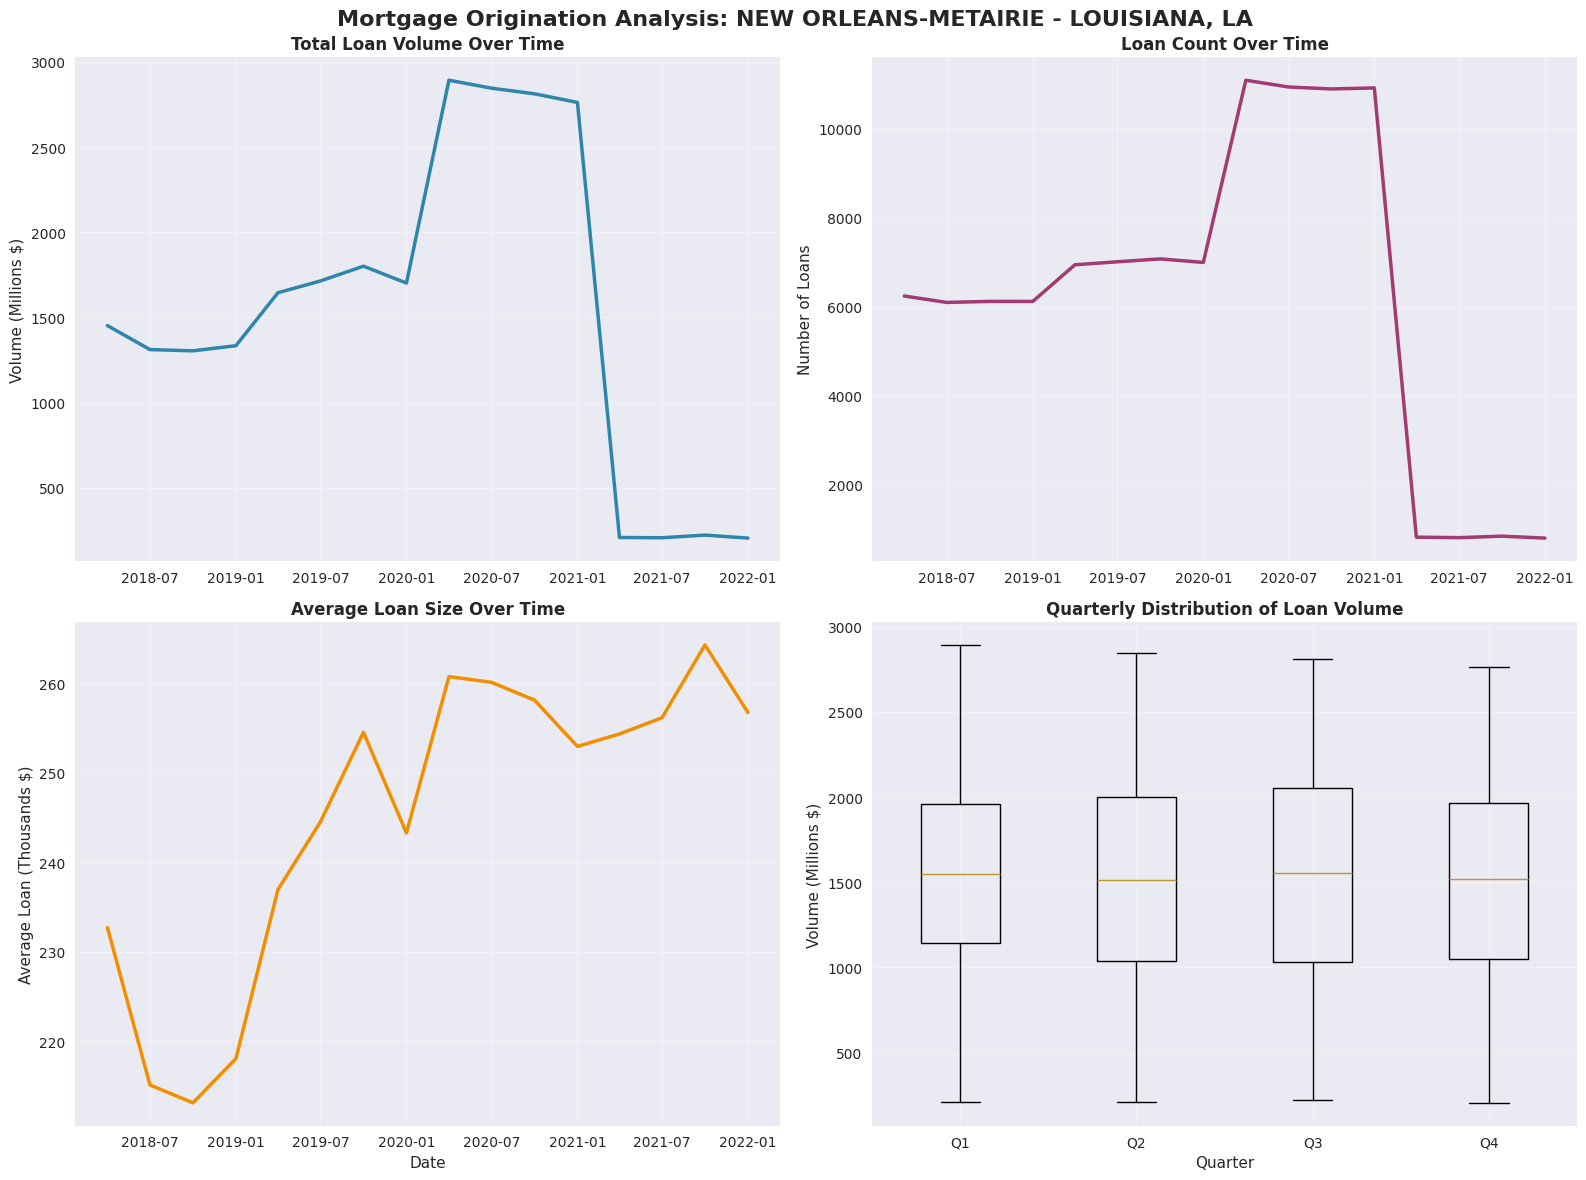

In [4]:
def plot_comprehensive_timeseries(data, title_suffix):
    """Create comprehensive time series plots"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Mortgage Origination Analysis: {title_suffix}', fontsize=16, fontweight='bold')
    
    # 1. Main time series
    axes[0,0].plot(data['date'], data['total_loan_volume'] / 1e6, 
                   linewidth=2.5, color='#2E86AB')
    axes[0,0].set_title('Total Loan Volume Over Time', fontweight='bold')
    axes[0,0].set_ylabel('Volume (Millions $)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Loan count
    axes[0,1].plot(data['date'], data['loan_count'], 
                   linewidth=2.5, color='#A23B72')
    axes[0,1].set_title('Loan Count Over Time', fontweight='bold')
    axes[0,1].set_ylabel('Number of Loans')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Average loan size
    axes[1,0].plot(data['date'], data['avg_loan_size'] / 1000, 
                   linewidth=2.5, color='#F18F01')
    axes[1,0].set_title('Average Loan Size Over Time', fontweight='bold')
    axes[1,0].set_ylabel('Average Loan (Thousands $)')
    axes[1,0].set_xlabel('Date')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Quarterly distribution (boxplot)
    data['quarter'] = data['date'].dt.quarter
    boxplot_data = [data[data['quarter'] == q]['total_loan_volume'] / 1e6 for q in range(1, 5)]
    axes[1,1].boxplot(boxplot_data, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    axes[1,1].set_title('Quarterly Distribution of Loan Volume', fontweight='bold')
    axes[1,1].set_ylabel('Volume (Millions $)')
    axes[1,1].set_xlabel('Quarter')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create comprehensive plots
fig = plot_comprehensive_timeseries(quarterly_data, config['data']['target_geography'])
plt.show()

# Save the figure
fig.savefig('../eda_comprehensive_analysis.png', dpi=300, bbox_inches='tight')

## 3. Seasonal Decomposition

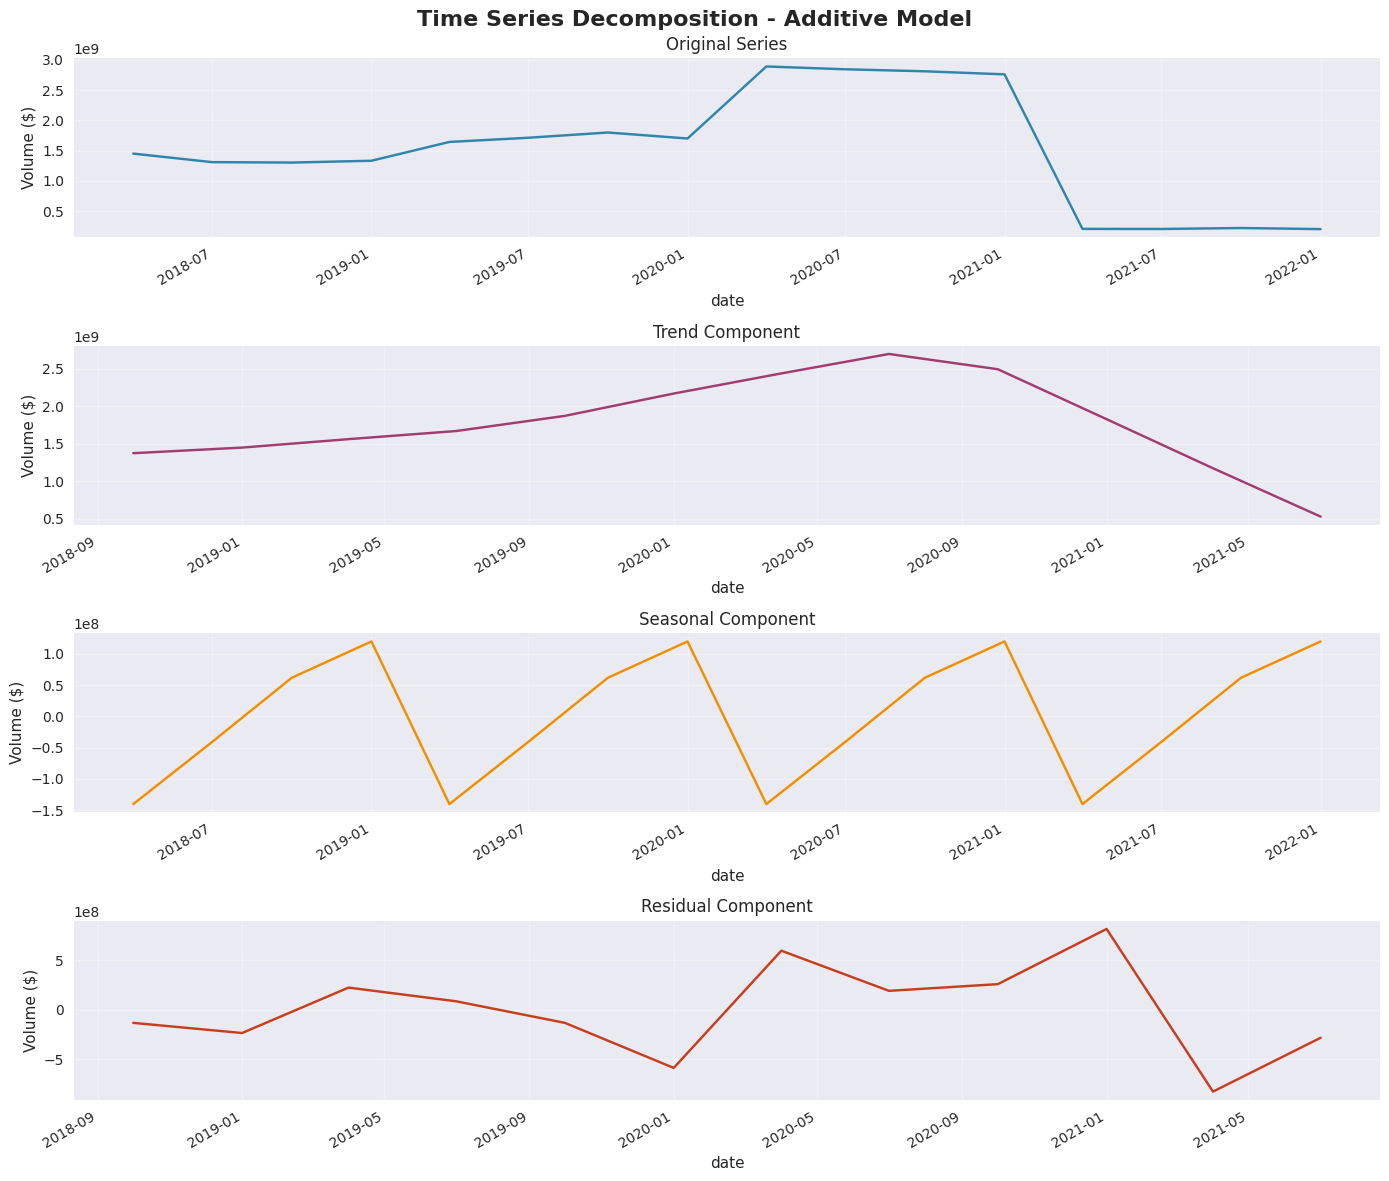

In [6]:
def decompose_timeseries(data, model='additive'):
    """Decompose time series into trend, seasonal, and residual components"""
    # Prepare the series
    ts_data = data.set_index('date')['total_loan_volume']
    ts_data = ts_data.asfreq('Q')
    
    # Perform decomposition
    decomposition = seasonal_decompose(ts_data, model=model, period=4)
    
    return decomposition

# Perform decomposition
decomposition = decompose_timeseries(quarterly_data)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('Time Series Decomposition - Additive Model', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], title='Original Series', color='#2E86AB')
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='#A23B72')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='#F18F01')
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='#C73E1D')

for ax in axes:
    ax.set_ylabel('Volume ($)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save decomposition plot
fig.savefig('../eda_seasonal_decomposition.png', dpi=300, bbox_inches='tight')

## 4. Statistical Analysis

In [7]:
def analyze_stationarity(series):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna())
    
    print("Augmented Dickey-Fuller Test:")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("Conclusion: Series is STATIONARY (reject null hypothesis)")
    else:
        print("Conclusion: Series is NON-STATIONARY (fail to reject null hypothesis)")
    
    return result

def calculate_seasonal_strength(series):
    """Calculate seasonal strength"""
    decomposition = seasonal_decompose(series, period=4)
    
    # Seasonal strength (0-1, higher means stronger seasonality)
    seasonal_strength = max(0, 1 - (decomposition.resid.var() / decomposition.observed.var()))
    
    return seasonal_strength

# Prepare the series
ts_volume = quarterly_data.set_index('date')['total_loan_volume']

# Stationarity analysis
print("=" * 60)
print("STATIONARITY ANALYSIS")
print("=" * 60)
adf_result = analyze_stationarity(ts_volume)

# Seasonal strength
seasonal_strength = calculate_seasonal_strength(ts_volume)
print(f"\nSeasonal Strength: {seasonal_strength:.3f}")

# Basic statistics
print("\n" + "=" * 60)
print("DESCRIPTIVE STATISTICS")
print("=" * 60)
print(f"Mean quarterly volume: ${ts_volume.mean():,.0f}")
print(f"Median quarterly volume: ${ts_volume.median():,.0f}")
print(f"Standard deviation: ${ts_volume.std():,.0f}")
print(f"Coefficient of variation: {ts_volume.std()/ts_volume.mean():.3f}")
print(f"Skewness: {ts_volume.skew():.3f}")
print(f"Kurtosis: {ts_volume.kurtosis():.3f}")

STATIONARITY ANALYSIS
Augmented Dickey-Fuller Test:
ADF Statistic: -3.043905
p-value: 0.030993
Critical Values:
  1%: -4.138
  5%: -3.155
  10%: -2.714
Conclusion: Series is STATIONARY (reject null hypothesis)

Seasonal Strength: 0.769

DESCRIPTIVE STATISTICS
Mean quarterly volume: $1,526,412,188
Median quarterly volume: $1,548,835,000
Standard deviation: $966,273,864
Coefficient of variation: 0.633
Skewness: -0.020
Kurtosis: -1.014


## 5. Correlation and Lag Analysis

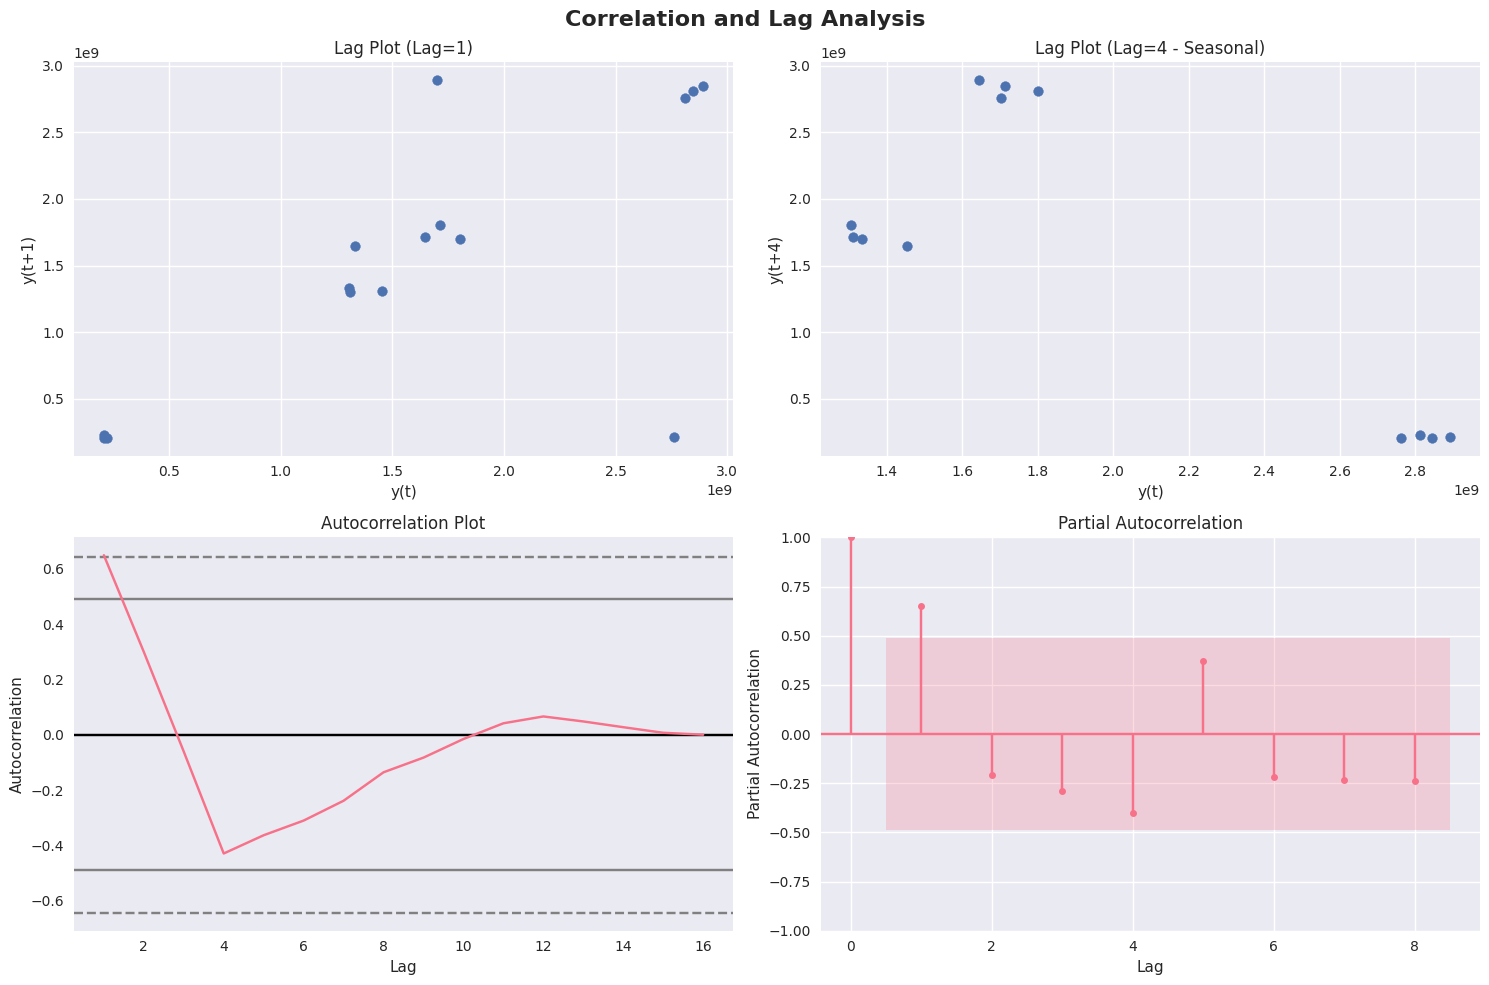

In [10]:
from pandas.plotting import autocorrelation_plot, lag_plot

def plot_correlation_analysis(series):
    """Plot ACF and lag analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Correlation and Lag Analysis', fontsize=16, fontweight='bold')
    
    # Lag plot (lag 1)
    lag_plot(series, ax=axes[0,0])
    axes[0,0].set_title('Lag Plot (Lag=1)')
    axes[0,0].set_xlabel('y(t)')
    axes[0,0].set_ylabel('y(t+1)')
    
    # Lag plot (lag 4 - seasonal)
    lag_plot(series, lag=4, ax=axes[0,1])
    axes[0,1].set_title('Lag Plot (Lag=4 - Seasonal)')
    axes[0,1].set_xlabel('y(t)')
    axes[0,1].set_ylabel('y(t+4)')
    
    # Autocorrelation plot
    autocorrelation_plot(series, ax=axes[1,0])
    axes[1,0].set_title('Autocorrelation Plot')
    axes[1,0].set_xlabel('Lag')
    axes[1,0].set_ylabel('Autocorrelation')
    
    # Partial autocorrelation (using statsmodels)
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_pacf(series, ax=axes[1,1], lags=8)
    axes[1,1].set_title('Partial Autocorrelation')
    axes[1,1].set_xlabel('Lag')
    axes[1,1].set_ylabel('Partial Autocorrelation')
    
    plt.tight_layout()
    return fig

# Plot correlation analysis
corr_fig = plot_correlation_analysis(ts_volume)
plt.show()
corr_fig.savefig('../eda_correlation_analysis.png', dpi=300, bbox_inches='tight')

## 6. Year-over-Year Analysis

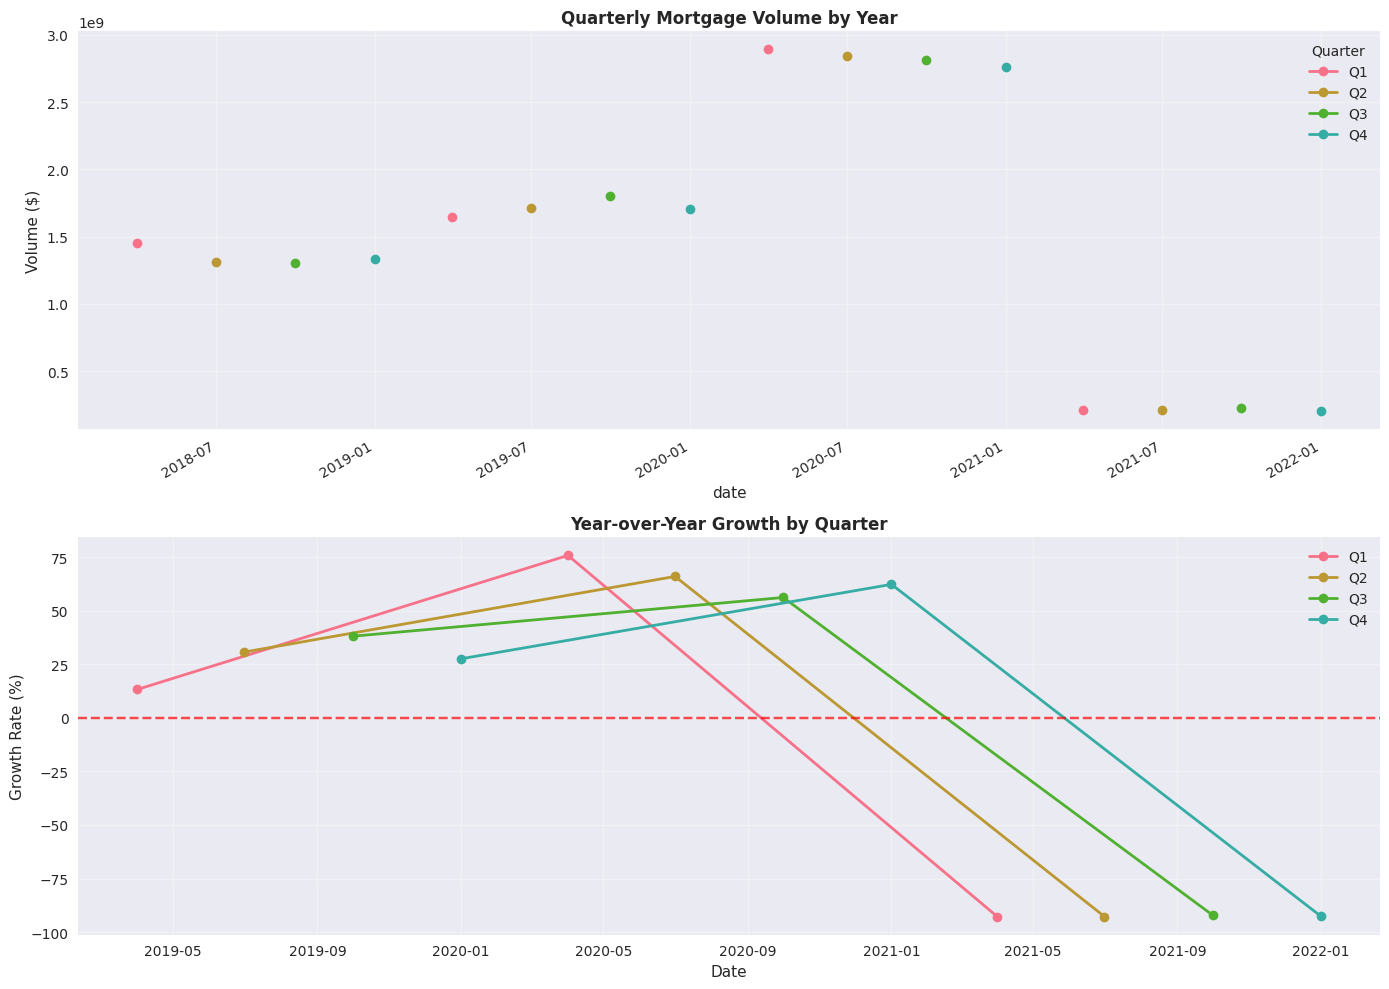

In [12]:
def analyze_yoy_growth(data):
    """Calculate and visualize year-over-year growth"""
    df = data.copy()
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    
    # Calculate YoY growth by quarter
    yoy_data = []
    for quarter in range(1, 5):
        quarter_data = df[df['quarter'] == quarter].sort_values('year')
        quarter_data['yoy_growth'] = quarter_data['total_loan_volume'].pct_change() * 100
        yoy_data.append(quarter_data)
    
    yoy_df = pd.concat(yoy_data).sort_values('date')
    
    return yoy_df

# Calculate YoY growth
yoy_analysis = analyze_yoy_growth(quarterly_data)

# Plot YoY growth
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Quarterly volumes by year
quarters_pivot = quarterly_data.pivot_table(
    index='date', 
    columns=quarterly_data['date'].dt.quarter, 
    values='total_loan_volume'
)
quarters_pivot.columns = [f'Q{col}' for col in quarters_pivot.columns]
quarters_pivot.plot(ax=ax1, marker='o', linewidth=2)
ax1.set_title('Quarterly Mortgage Volume by Year', fontweight='bold')
ax1.set_ylabel('Volume ($)')
ax1.legend(title='Quarter')
ax1.grid(True, alpha=0.3)

# YoY growth
for quarter in range(1, 5):
    quarter_data = yoy_analysis[yoy_analysis['quarter'] == quarter]
    ax2.plot(quarter_data['date'], quarter_data['yoy_growth'], 
             marker='o', linewidth=2, label=f'Q{quarter}')

ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Year-over-Year Growth by Quarter', fontweight='bold')
ax2.set_ylabel('Growth Rate (%)')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig.savefig('../eda_yoy_analysis.png', dpi=300, bbox_inches='tight')

## 7. Outlier Detection

Outlier Detection:
Z-score outliers (0):

IQR outliers (0):

IQR bounds: [$-477,200,000, $3,552,520,000]


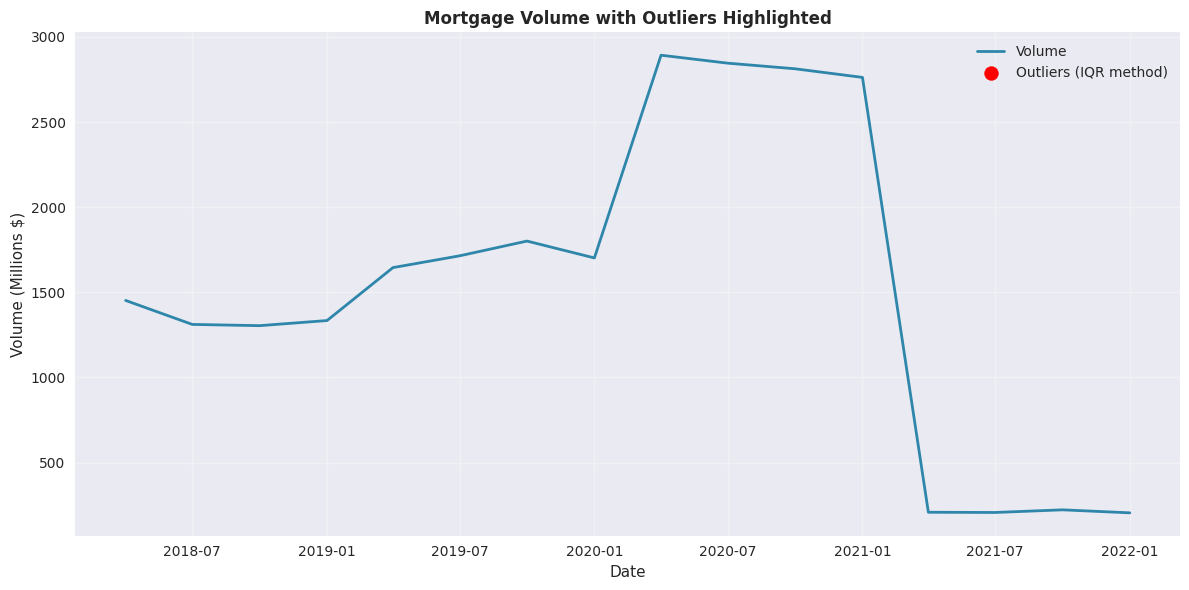

In [14]:
def detect_outliers_zscore(series, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(series))
    outliers = series[z_scores > threshold]
    
    return outliers

def detect_outliers_iqr(series):
    """Detect outliers using IQR method"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    
    return outliers, (lower_bound, upper_bound)

# Detect outliers
zscore_outliers = detect_outliers_zscore(ts_volume)
iqr_outliers, iqr_bounds = detect_outliers_iqr(ts_volume)

print("Outlier Detection:")
print(f"Z-score outliers ({len(zscore_outliers)}):")
for date, value in zscore_outliers.items():
    print(f"  {date.date()}: ${value:,.0f}")

print(f"\nIQR outliers ({len(iqr_outliers)}):")
for date, value in iqr_outliers.items():
    print(f"  {date.date()}: ${value:,.0f}")

print(f"\nIQR bounds: [${iqr_bounds[0]:,.0f}, ${iqr_bounds[1]:,.0f}]")

# Plot with outliers highlighted
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(quarterly_data['date'], quarterly_data['total_loan_volume'] / 1e6, 
        linewidth=2, color='#2E86AB', label='Volume')

# Highlight outliers
outlier_dates = iqr_outliers.index
outlier_values = iqr_outliers.values / 1e6
ax.scatter(outlier_dates, outlier_values, color='red', s=100, 
          zorder=5, label='Outliers (IQR method)')

ax.set_title('Mortgage Volume with Outliers Highlighted', fontweight='bold')
ax.set_ylabel('Volume (Millions $)')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig.savefig('../eda_outlier_detection.png', dpi=300, bbox_inches='tight')

## 8. Key Insights Summary

In [15]:
def generate_insights_summary(data, decomposition, adf_result, seasonal_strength):
    """Generate a summary of key insights"""
    
print("=" * 70)
print("EXPLORATORY DATA ANALYSIS - KEY INSIGHTS")
print("=" * 70)
print(f"\nGeography: {config['data']['target_geography']}")
print(f"Analysis Period: {quarterly_data['date'].min().date()} to {quarterly_data['date'].max().date()}")
print(f"Total Quarters Analyzed: {len(quarterly_data)}")

print("\n📈 TREND ANALYSIS:")
trend_slope = decomposition.trend.dropna()
if len(trend_slope) > 1:
    trend_direction = "UPWARD" if trend_slope.iloc[-1] > trend_slope.iloc[0] else "DOWNWARD"
    trend_strength = abs((trend_slope.iloc[-1] - trend_slope.iloc[0]) / trend_slope.iloc[0]) * 100
    print(f"  • Overall {trend_direction} trend ({trend_strength:.1f}% change)")

print("\n📅 SEASONALITY ANALYSIS:")
print(f"  • Seasonal strength: {seasonal_strength:.3f}")
if seasonal_strength > 0.6:
    print("  • STRONG seasonal patterns detected")
elif seasonal_strength > 0.3:
    print("  • MODERATE seasonal patterns detected")
else:
    print("  • WEAK seasonal patterns")

print("\n📊 STATIONARITY:")
if adf_result[1] <= 0.05:
    print("  • Series is STATIONARY (good for modeling)")
else:
    print("  • Series is NON-STATIONARY (may need differencing)")

print("\n🎯 OUTLIERS:")
print(f"  • {len(iqr_outliers)} potential outliers detected")
if len(iqr_outliers) > 0:
    print("  • Consider investigating these periods for special events")

print("\n💡 MODELING RECOMMENDATIONS:")
if seasonal_strength > 0.4 and adf_result[1] > 0.05:
    print("  • SARIMA model recommended (handles seasonality and non-stationarity)")
elif seasonal_strength > 0.4:
    print("  • SARIMA or Seasonal Naive model recommended")
else:
    print("  • ARIMA or ETS models may be sufficient")

print("\n" + "=" * 70)

EXPLORATORY DATA ANALYSIS - KEY INSIGHTS

Geography: NEW ORLEANS-METAIRIE - LOUISIANA, LA
Analysis Period: 2018-03-31 to 2021-12-31
Total Quarters Analyzed: 16

📈 TREND ANALYSIS:
  • Overall DOWNWARD trend (61.4% change)

📅 SEASONALITY ANALYSIS:
  • Seasonal strength: 0.769
  • STRONG seasonal patterns detected

📊 STATIONARITY:
  • Series is STATIONARY (good for modeling)

🎯 OUTLIERS:
  • 0 potential outliers detected

💡 MODELING RECOMMENDATIONS:
  • SARIMA or Seasonal Naive model recommended



## Summary

In this EDA notebook we:
1. Visualized the time series from multiple perspectives
2. Decomposed the series into trend, seasonal, and residual components
3. Tested for stationarity using ADF test
4. Analyzed autocorrelation and partial autocorrelation
5. Examined year-over-year growth patterns
6. Detected and analyzed outliers
7. Generated key insights for modeling

The data shows clear patterns that will inform our model selection in the next notebook.